In [10]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.ndimage import median_filter

In [11]:
# Constants
n = 3 # Glen's flow parameters
A = 2.4e-24  

rho_i = 911  # ice density [kg/m^3] 
rho_d = 1800 # debris density 
yr2sec = np.pi * 1e7 # [s/yr]
g = 9.8 # gravity [m/s^2]

In [12]:

# Import geotiffs

# Import slope map for depth inversion
with rasterio.open('LC_slope_1m.tif') as src_slope:
    alpha = src_slope.read(1).astype(float)
    transform_slope = src_slope.transform

alpha[alpha == -9999] = np.nan
alpha = np.radians(alpha) # convert to radians

dt = 1

# Import velocity component rasters
dat_path = './'
with rasterio.open(f'{dat_path}LC_1m_dx.tif') as src_vx:
    vx = src_vx.read(1).astype(float) / dt
    transform_vx = src_vx.transform

# replace no data with NaN values if any exist
vx[vx == -4.999950000000000e+04] = np.nan

# load y velocity 
with rasterio.open(f'{dat_path}LC_1m_dy.tif') as src_vy:
    vy = src_vy.read(1).astype(float) / dt

# replace no data with NaN values if any exist
vy[vy == -4.999950000000000e+04] = np.nan

vx[np.abs(vx) > 10] = 0
vy[np.abs(vy) > 10] = 0

REF_file = 'LC_1m_dx.tif'


Ice fraction:
[0.9]
Bulk density [kg m^-3]:
[1086.9]


/var/tmp/ipykernel_3314831/2100218230.py:58: RuntimeWarning: divide by zero encountered in divide
  H_kon = ((Hk1 / Hk2) + Hk3)**(0.25) - Hk4
/var/tmp/ipykernel_3314831/2100218230.py:58: RuntimeWarning: invalid value encountered in divide
  H_kon = ((Hk1 / Hk2) + Hk3)**(0.25) - Hk4


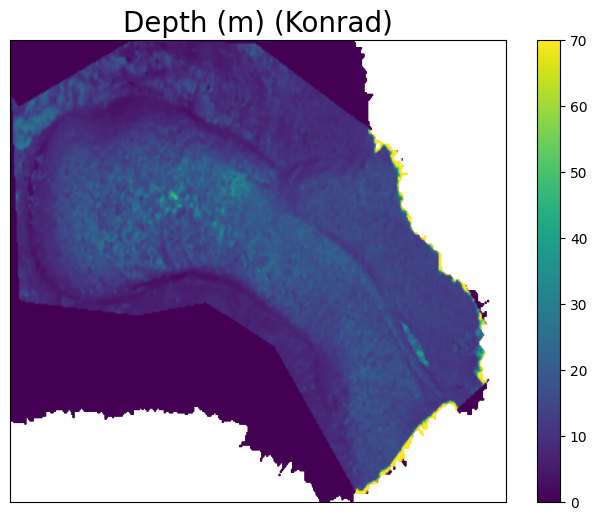

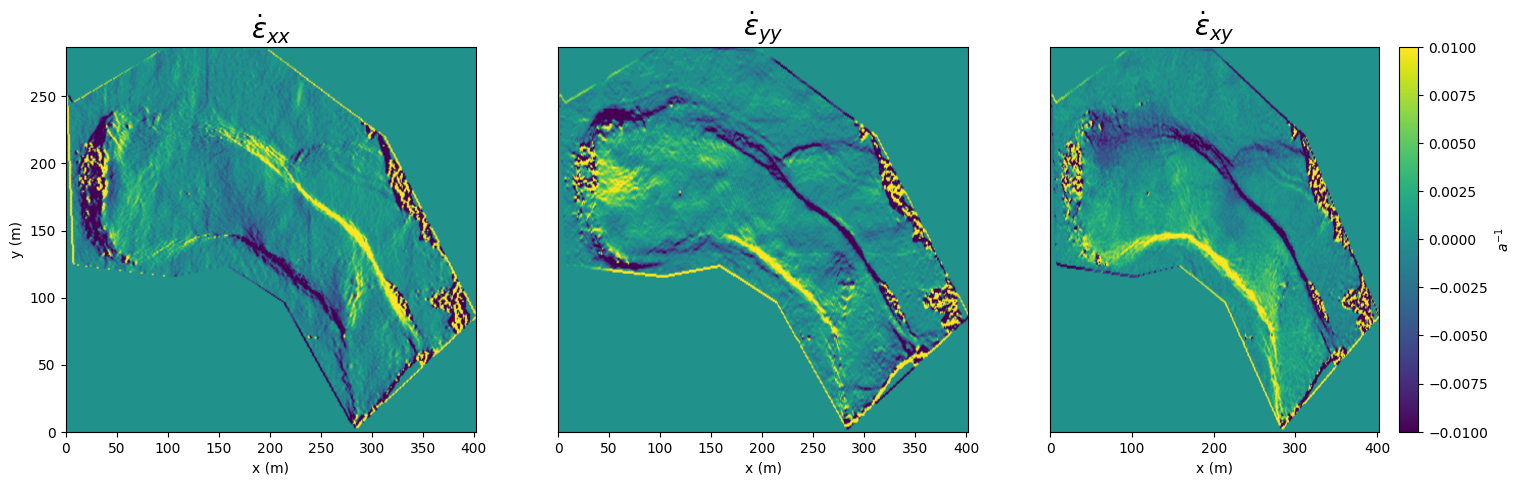

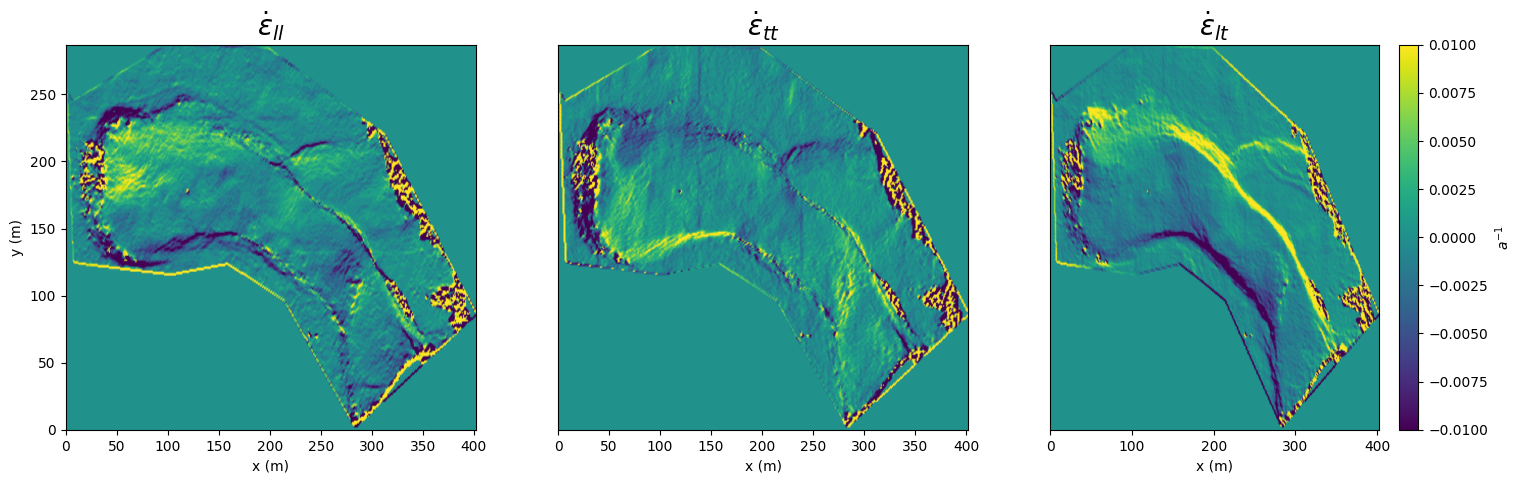

In [13]:


# Apply filters (scipy's median_filter defaults to size 3, similar to MATLAB's medfilt2)
vx = median_filter(vx, size=3)
vy = median_filter(vy, size=3)

# Extract spatial dimensions (cell size)
dx = transform_vx[0]
dy = -transform_vx[4] # Usually negative in GeoTIFFs

# Create spatial dimension vectors (for plotting)
nx, ny = vx.shape[1], vx.shape[0]
Rx = np.linspace(transform_vx[2] + dx/2, transform_vx[2] + dx*nx - dx/2, nx)
Ry = np.linspace(transform_vx[5] - dy/2, transform_vx[5] - dy*ny + dy/2, ny)

# Calculate spatial gradients (Strain Rates)
# np.gradient handles the boundaries similarly to MATLAB
eps_yy = -np.gradient(vy, dy, axis=0) # longitudinal derivative along y (rows)
eps_xx = np.gradient(vx, dx, axis=1)  # longitudinal derivative along x (cols)

eps_xyA = np.gradient(vx, dy, axis=0) # shear first half
eps_xyB = np.gradient(vy, dx, axis=1) # shear second half

eps_xy = 0.5 * (eps_xyA + eps_xyB) # full shear strain rate

# Tensor Rotation
theta_deg = 110
theta = np.radians(theta_deg)
c, s = np.cos(theta), np.sin(theta)

# Vectorized tensor rotation (Much faster in Python than nested loops)
# sigma_prime = Q * sigma * Q.T
eps_ll = c**2 * eps_xx + 2*s*c * eps_xy + s**2 * eps_yy
eps_tt = s**2 * eps_xx - 2*s*c * eps_xy + c**2 * eps_yy
eps_lt = -s*c * eps_xx + (c**2 - s**2) * eps_xy + s*c * eps_yy

# Density estimation for driving stress and thickness calculation
rho_r = 2670
fraction_ice = np.arange(0, 1.01, 0.01)
rho_vals = fraction_ice * rho_i + (1 - fraction_ice) * rho_r

print('Ice fraction:')
print(fraction_ice[np.isclose(fraction_ice, 0.9)])
print('Bulk density [kg m^-3]:')
print(rho_vals[np.isclose(fraction_ice, 0.9)])

rho_gc = 1100 # estimated rock glacier density 
tau0 = 1e5    # yield stress

# Depth estimate using Potter's method
V = np.sqrt(vx**2 + vy**2)
u0 = V * 100 * (1 / yr2sec) # surface velocity in cm/s

d = 1.5 # debris thickness (m)

Hk1 = u0 / 100 * (n + 1)
Hk2 = 2 * A * (rho_i * g * np.sin(median_filter(alpha, size=3)))**n
Hk3 = (rho_d / rho_i) * (d**(n + 1))
Hk4 = (rho_d / rho_i) * d
H_kon = ((Hk1 / Hk2) + Hk3)**(0.25) - Hk4

# Plotting
# Note: In matplotlib, origin='lower' handles the axis orientation properly without needing flipud most of the time, 
# but to strictly match MATLAB's `pcolor(..., flipud(Z))` behavior:

plt.figure(3, figsize=(8, 6))
# Using pcolormesh for efficient raster plotting
plt.pcolormesh(H_kon, shading='gouraud', cmap='viridis', vmin=0, vmax=70)
plt.gca().invert_yaxis() # equivalent to axis ij
plt.colorbar()
plt.title('Depth (m) (Konrad)', fontsize=20)
plt.xticks([])
plt.yticks([])

eps_range = 0.01

fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5))
titles1 = [r'$\dot{\epsilon}_{xx}$', r'$\dot{\epsilon}_{yy}$', r'$\dot{\epsilon}_{xy}$']
# data1 = [np.flipud(eps_xx), np.flipud(eps_yy), np.flipud(eps_xy)]
data1 = [eps_xx, eps_yy, eps_xy]


for ax, dat, title in zip(axes1, data1, titles1):
    mesh = ax.pcolormesh(Rx - np.min(Rx), Ry - np.min(Ry), dat, shading='gouraud', vmin=-eps_range, vmax=eps_range)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('x (m)')
axes1[0].set_ylabel('y (m)')
axes1[1].set_yticks([])
axes1[2].set_yticks([])
cbar = fig1.colorbar(mesh, ax=axes1[2])
cbar.set_label('$a^{-1}$')

fig4, axes4 = plt.subplots(1, 3, figsize=(18, 5))
titles4 = [r'$\dot{\epsilon}_{ll}$', r'$\dot{\epsilon}_{tt}$', r'$\dot{\epsilon}_{lt}$']
data4 = [eps_ll, eps_tt, eps_lt]

for ax, dat, title in zip(axes4, data4, titles4):
    mesh = ax.pcolormesh(Rx - np.min(Rx), Ry - np.min(Ry), dat, shading='gouraud', vmin=-eps_range, vmax=eps_range)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('x (m)')
axes4[0].set_ylabel('y (m)')
axes4[1].set_yticks([])
axes4[2].set_yticks([])
cbar = fig4.colorbar(mesh, ax=axes4[2])
cbar.set_label('$a^{-1}$')

plt.show()





In [8]:
def save_raster(A_matrix, geotiff_ref, fname, epsg_code):
    """
    Function to export matrix to projected geotiff file using same projection
    as previously used geotiff.
    """
    tiffile = f"{fname}.tif"
    with rasterio.open(geotiff_ref) as src:
        profile = src.profile
    
    # Update the profile to ensure data types match and we use the desired EPSG
    profile.update(
        dtype=rasterio.float32,
        count=1,
        crs=rasterio.crs.CRS.from_epsg(epsg_code)
    )
    
    with rasterio.open(tiffile, 'w', **profile) as dst:
        dst.write(A_matrix.astype(rasterio.float32), 1)

In [9]:
epsg = 2056 # Les Cliosses



# Uncomment to export raster files
# save_raster(H_kon, REF_file, 'H_kon_23', 32612)
# save_raster(eps_tt, REF_file, 'LC1m_epsilontt', epsg)
# save_raster(eps_ll, REF_file, 'LC1m_epsilonll', epsg)
# save_raster(eps_lt, REF_file, 'LC1m_epsilonlt', epsg)